# Amsterdam: SQL queries, times series, reviews, verifications and licenses 

Let's import useful packages:

In [1]:
import gzip
import json
import csv
import sqlite3
import pandas as pd
import numpy as np
from scipy import stats

Visualization tools:

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import folium

In [3]:
import sys
# !{sys.executable} -m pip install -U folium

In this last analysis, we create a database in Python using *sqlite3* importing a DataFrame using Pandas. The step 1 is create a database called BookingsDB.

In [4]:
conn = sqlite3.connect('../Data/database/BookingsDB.db') 

In [5]:
c = conn.cursor()

In [6]:
read_listing = pd.read_csv('../Data/raw/listings.csv.gz', 
                      compression='gzip',
                      error_bad_lines=False, 
                      low_memory=False)

In [7]:
read_listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

In [8]:
read_listing.loc[:, 'calendar_updated': 'calendar_last_scraped'].head(2)

,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped
0,2 months ago,t,0,0,0,0,2019-12-08
1,yesterday,t,4,21,51,198,2019-12-08


In [9]:
read_listing.to_sql('LISTINGS', conn, if_exists='append', index = False) # Insert the values from the csv file into the table 'CLIENTS' 

In [10]:
c.execute('''
        SELECT availability_30, COUNT(*) 
        FROM LISTINGS 
        GROUP BY availability_30
        ORDER BY availability_30
''')

In [11]:
print('AVAILABLE DAYS IN THE NEXT 30 DAYS \n----------------------------------')
for i in c.fetchall():
    if i[0]%5 == 0:
        print(str(i[1]) + ' listings availables ' + str(i[0]) + ' days')

AVAILABLE DAYS IN THE NEXT 30 DAYS 
----------------------------------
63120 listings availables 0 days
1985 listings availables 5 days
1465 listings availables 10 days
1005 listings availables 15 days
835 listings availables 20 days
625 listings availables 25 days
995 listings availables 30 days


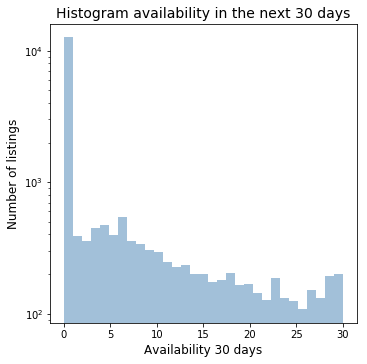

In [12]:
_ = plt.figure(figsize=(5.5, 5.5))
_ = plt.yscale('log')
_ = plt.hist(read_listing.availability_30.dropna(), bins=31, alpha=0.5, facecolor='steelblue')
_ = plt.xlabel('Availability 30 days', size=12)
_ = plt.ylabel('Number of listings', size=12)
_ = plt.title('Histogram availability in the next 30 days', size=14)
# _ = plt.xlim(-0.5, 5.5)

In [13]:
c.execute('''
        SELECT availability_60, COUNT(*) 
        FROM LISTINGS 
        GROUP BY availability_60
        ORDER BY availability_60
''')

In [14]:
print('AVAILABLE DAYS IN THE NEXT 60 DAYS \n----------------------------------')
for i in c.fetchall():
    if i[0]%10 == 0:
        print(str(i[1]) + ' listings availables ' + str(i[0]) + ' days')

AVAILABLE DAYS IN THE NEXT 60 DAYS 
----------------------------------
60180 listings availables 0 days
1045 listings availables 10 days
565 listings availables 20 days
420 listings availables 30 days
485 listings availables 40 days
450 listings availables 50 days
875 listings availables 60 days


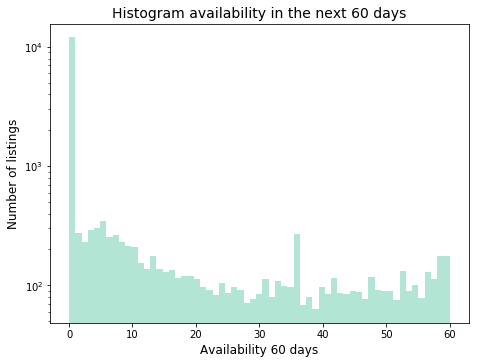

In [15]:
_ = plt.figure(figsize=(7.5, 5.5))
_ = plt.yscale('log')
_ = plt.hist(read_listing.availability_60.dropna(), bins=61, alpha=0.5, facecolor='mediumaquamarine')
_ = plt.xlabel('Availability 60 days', size=12)
_ = plt.ylabel('Number of listings', size=12)
_ = plt.title('Histogram availability in the next 60 days', size=14)

In [16]:
c.execute('''
        SELECT availability_90, COUNT(*) 
        FROM LISTINGS 
        GROUP BY availability_90
        ORDER BY availability_90
''')

In [17]:
print('AVAILABLE DAYS IN THE NEXT 90 DAYS \n----------------------------------')
for i in c.fetchall():
    if i[0]%10 == 0:
        print(str(i[1]) + ' listings availables ' + str(i[0]) + ' days')

AVAILABLE DAYS IN THE NEXT 90 DAYS 
----------------------------------
58275 listings availables 0 days
895 listings availables 10 days
535 listings availables 20 days
270 listings availables 30 days
255 listings availables 40 days
230 listings availables 50 days
295 listings availables 60 days
335 listings availables 70 days
365 listings availables 80 days
830 listings availables 90 days


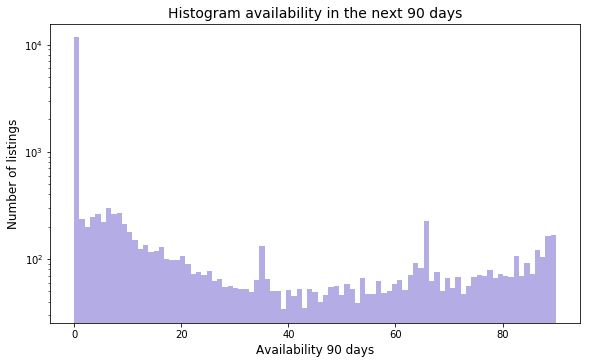

In [18]:
_ = plt.figure(figsize=(9.5, 5.5))
_ = plt.yscale('log')
_ = plt.hist(read_listing.availability_90.dropna(), bins=91, alpha=0.5, facecolor='slateblue')
_ = plt.xlabel('Availability 90 days', size=12)
_ = plt.ylabel('Number of listings', size=12)
_ = plt.title('Histogram availability in the next 90 days', size=14)
# _ = plt.xlim(-0.5, 5.5)

A brief inspection of columns enable us to split them according to the following **different categories of information**:

1. **General information of booking**: id, name, summary, description, space, experiences_offered, neighborhood overview, notes, transit, access, interaction, house_rules. To access that, select columns from `id` to `house_rules`.

2. **Host information**: id, name, location, about, response time, response rate, acceptance rate, listings count, verifications. In this case, select columns from `host_id` to `host_identity_verified`.

3. All about the **neighborhood**: city, state, market, cleansed. Extract this information selecting columns from `street` to `is_location_exact`.

4. Details of **property and conditions** are between the columns `property_type` and `maximum_nights_avg_ntm`.

5. **Calendar updates and availability** the next 30, 60 and 90 days, for instances. You can find this information between the columns `calendar_updated` and `calendar_last_scraped`.

6. **Reviews**: first and last review, number of reviews, scores rating, scores per accuracy, cleanliness, checkin, communication, location and value. Columns from `number of reviews` to `review_scores_value`.

7. **Verifications and licenses**: require guest profile picture, phone verification, cancellation policy, instant bookeable. Columns from `requires_license` to `require_guest_phone_verification`.

8. **Host listings counts** and reviews per month. Select from `calculated_host_listings_count` to `reviews_per_month`.

### Which neighborhoods have more and less availability in the next three months?

1. Filtering listings without availability. Check `has_avalability`.
2. Filtering listings without recent updates in their calendars. Check `calendar_updated`.
3. Analyze the availability in the next 30, 60 and 90 days in every booking. 

In [19]:
df_calendar = read_listing.loc[:, 'calendar_updated': 'calendar_last_scraped']

In [20]:
df_id = read_listing.loc[:, ['id', 'neighbourhood_cleansed']]

In [21]:
calendar_id = pd.concat([df_id, df_calendar,], axis=1, sort=False)

In [22]:
calendar_id.head()

,id,neighbourhood_cleansed,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped
0,2818,Oostelijk Havengebied - Indische Buurt,2 months ago,t,0,0,0,0,2019-12-08
1,20168,Centrum-Oost,yesterday,t,4,21,51,198,2019-12-08
2,25428,Centrum-West,3 months ago,t,2,26,26,71,2019-12-08
3,27886,Centrum-West,yesterday,t,16,43,69,251,2019-12-08
4,28871,Centrum-West,4 months ago,t,0,2,10,134,2019-12-08


#### 1. Filtering listings without availability

According to the below result, all bookings are valid to include in the analysis:

In [23]:
calendar_id.groupby('has_availability').count()

,id,neighbourhood_cleansed,calendar_updated,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped
has_availability,,,,,,,,
t,20025,20025,20025,20025,20025,20025,20025,20025


#### 2. Filtering listings without recent updates in their calendars


Firstly, we check all the possible strings in `calendar_updated` column:

In [24]:
calendar_id.calendar_updated.unique()

array(['2 months ago', 'yesterday', '3 months ago', '4 months ago',
       '12 months ago', '2 weeks ago', '6 days ago', '1 week ago',
       '24 months ago', 'today', '3 weeks ago', 'a week ago',
       '4 weeks ago', '14 months ago', '9 months ago', '5 weeks ago',
       '26 months ago', '4 days ago', '5 months ago', '3 days ago',
       '5 days ago', '19 months ago', '6 weeks ago', '27 months ago',
       '7 weeks ago', '6 months ago', '10 months ago', '7 months ago',
       '37 months ago', '35 months ago', '28 months ago', '8 months ago',
       '15 months ago', '20 months ago', '45 months ago', '34 months ago',
       '21 months ago', '18 months ago', '17 months ago', '13 months ago',
       'never', '25 months ago', '29 months ago', '16 months ago',
       '2 days ago', '22 months ago', '54 months ago', '48 months ago',
       '46 months ago', '40 months ago', '43 months ago', '47 months ago',
       '31 months ago', '32 months ago', '39 months ago', '23 months ago',
       '33 

Using this information, the method `updated_days ago` is created to replace the strings for numerical values:

In [25]:
def updated_days_ago(calendar_updated):
    """
    Transformation of the string expressions from the calendar_updated column in numerical days,
    considering that every month has 30 days and the inputs 'today' and 'yesterday' means 0 and 1 days 
    ago respectively. For instances, '1 week ago' is replaced by 7 days and '2 months ago' is 60 days.
    """
    if calendar_updated == 'today':
        days_ago = 0
    elif calendar_updated == 'yesterday':
          days_ago = 1
    elif calendar_updated == 'a week ago':
          days_ago = 7
    else:
        string = calendar_updated.split(' ')
        if len(string) > 1:
            scale = string[1]
            value = string[0]

            if scale.startswith('day'):
                if value.isnumeric():
                    days_ago = float(value)
                else:
                    days_ago = np.nan
            elif scale.startswith('week'):
                if value.isnumeric():
                    days_ago = float(value)*7
                else:
                    days_ago = np.nan
            elif scale.startswith('month'):
                if value.isnumeric():
                    days_ago = float(value)*30
                else:
                    days_ago = np.nan
        else:
            days_ago = np.nan
            
            
    return days_ago

In [26]:
calendar_id['updated'] = calendar_id.calendar_updated.apply(updated_days_ago)

Displaying the calendar updated boxplot to detect outliers visually:

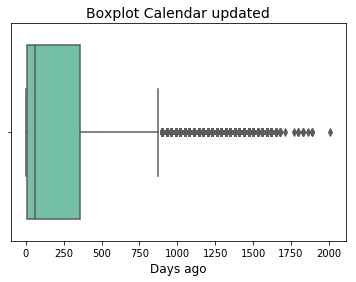

In [27]:
_ = sns.boxplot(calendar_id.updated, color='mediumaquamarine')
_ = plt.xlabel('Days ago', size=12)
_ = plt.title('Boxplot Calendar updated', size=14)

The result indicates that a concentration of updates in calendar **between 0 days and 1 year ago**. Therefore, the belated listings are removed in the next analysis.

In [28]:
recent_updates = calendar_id[calendar_id['updated'] <= 365]

#### 3. Analyze the availability in the next 30, 60 and 90 days in every neighborhood

In [29]:
recent_updates.loc[:, 'count'] = 1

/Users/daniela/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/daniela/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [30]:
centre_district = ['Centrum-Oost', 'Centrum-West']
district_nieuw_west = ['Osdorp', 'De Aker - Nieuw Sloten', 'Slotervaart', 'Geuzenveld - Slotermeer']
district_noord = ['Oud-Noord', 'Noord-Oost', 'Noord-West']
district_oost = ['Oostelijk Havengebied - Indische Buurt', 'Oud-Oost', 'IJburg - Zeeburgereiland', 'Watergraafsmeer']
district_west = ['De Baarsjes - Oud-West', 'Bos en Lommer', 'Westerpark']
district_zuid = ['Buitenveldert - Zuidas', 'De Pijp - Rivierenbuurt', 'Zuid']
district_zuidoost = ['Bijlmer-Centrum', 'Bijlmer-Oost', 'Gaasperdam - Driemond']

def district(neighborhood):
    if neighborhood in centre_district:
        district = 'centre_district'
    elif neighborhood in district_nieuw_west:
        district = 'district_nieuw_west'
    elif neighborhood in district_noord:
        district = 'district_noord'
    elif neighborhood in district_oost:
        district = 'district_oost'
    elif neighborhood in district_west:
        district = 'district_west'
    elif neighborhood in district_zuid:
        district = 'district_zuid'
    elif neighborhood in district_zuidoost:
        district = 'district_zuidoost'
    else:
        district = np.nan     
        
    return district

In [31]:
recent_updates.loc[:, 'district'] = recent_updates.neighbourhood_cleansed.apply(district)

In [32]:
recent_updates.head()

,id,neighbourhood_cleansed,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,updated,count,district
0,2818,Oostelijk Havengebied - Indische Buurt,2 months ago,t,0,0,0,0,2019-12-08,60.0,1,district_oost
1,20168,Centrum-Oost,yesterday,t,4,21,51,198,2019-12-08,1.0,1,centre_district
2,25428,Centrum-West,3 months ago,t,2,26,26,71,2019-12-08,90.0,1,centre_district
3,27886,Centrum-West,yesterday,t,16,43,69,251,2019-12-08,1.0,1,centre_district
4,28871,Centrum-West,4 months ago,t,0,2,10,134,2019-12-08,120.0,1,centre_district


In [33]:
available_30 = recent_updates.groupby(['district', 'availability_30']).count().reset_index().loc[:, ['district','availability_30', 'count']]

In [34]:
district = recent_updates.groupby(['district']).count().reset_index().loc[:, ['district', 'count']]

In [35]:
available_30_district = pd.merge(available_30, district, on=['district', 'district'])

In [36]:
available_30_district['percent'] = available_30_district['count_x']/available_30_district['count_y']

In [37]:
available_30_district.head()

,district,availability_30,count_x,count_y,percent
0,centre_district,0,1285,3157,0.407032
1,centre_district,1,84,3157,0.026608
2,centre_district,2,71,3157,0.022490
3,centre_district,3,92,3157,0.029142
4,centre_district,4,112,3157,0.035477


#### Percentage of listings without availability in the next 30 days

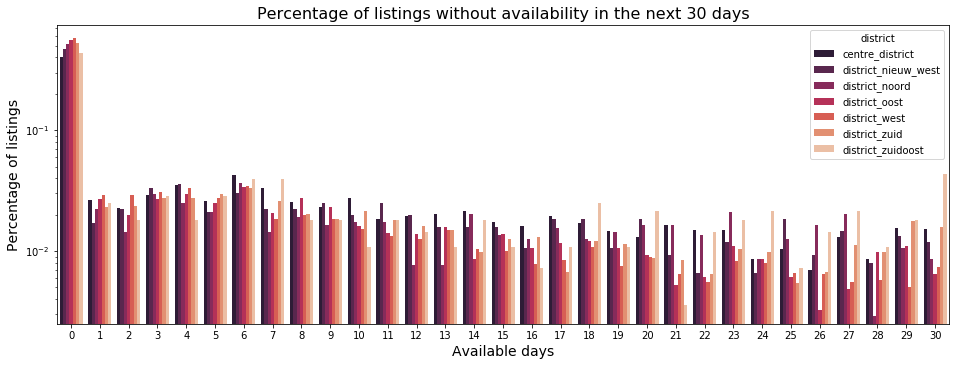

In [38]:
_ = plt.figure(figsize=(16, 5.5))
_ = plt.yscale('log')
_ = sns.barplot(x='availability_30', 
                y='percent', 
                palette='rocket',
                hue='district',
                data=available_30_district)
_ = plt.xlabel('Available days', size=14)
_ = plt.ylabel('Percentage of listings', size=14)
_ = plt.title('Percentage of listings without availability in the next 30 days', size=16)

The horizontal axis represent the number of available days in the calendar of every listing. The vertical axis is the percentage of listings with the respective available days into every district. As we checked before plotting the available days per bookings, the majority of the listings don't have available days in the next 30 days. It means that 0 available days concentrate a huge group of bookings. If we group that bookings per district, we realize that the District West have the highest % of listings completely reserved in the next month (this percentage is calculated considering the total of listins by district), followed by District Oost, Zuid and Noord. On the other hand, if we check bookings with the half of days availables in the next 30 days, the Centre District has the highest % of bookings availables. And finally, considering the bookings without reservations (30 available days), the district Zuidoost has the highest % of listings availables.